## Imports and setup

In [1]:
import os
import random
import pprint
from uuid import uuid4
import json

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import Image

from project.utils import multi_hot, make_iou, choose_params, f1
from project.models import create_model_with_feature_extractor
from project.preprocess_ingredients import preprocess_ingredients, decode_ingredients
from project.dataset import load_dataset_for_ingredient_prediction, train_val_test_split
from project.augmentation import make_augmentation, make_resizer

%load_ext autoreload
%autoreload 2

In [2]:
DATASET_ROOT = os.path.join("project", "dataset")
DATASET_CSV_PATH = os.path.join(DATASET_ROOT, "Food Ingredients and Recipe Dataset with Image Name Mapping.csv")

RUN_DIR = "./runs/resnet"
FEATURE_EXTRACTOR = "resnet"
IMG_SIZE = 224
CROP_SIZE = 200 
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_SIZE = 1024
EARLY_STOPPING_PATIENCE = 3
IOU_THRESH = 0.5
MAX_EPOCHS = 25

## GPU check

In [3]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load dataset

In [4]:
images, ingredients, valid_ingredients_list, dataset_size = load_dataset_for_ingredient_prediction(
    csv_file_path=DATASET_CSV_PATH, 
    preprocess_func=preprocess_ingredients,
    is_ipynb=True
)

NUM_INGREDIENTS = len(valid_ingredients_list)

#multi-hot encode ingredients
ingredients_multihot = ingredients.map(lambda x: multi_hot(x, NUM_INGREDIENTS), num_parallel_calls=tf.data.AUTOTUNE)

Dataset columns: ['id', 'Title', 'Ingredients', 'Instructions', 'Image_Name', 'Cleaned_Ingredients']
Removed 8 rows containing NaN
current path for images: project\dataset\Food Images\Food Images


In [5]:
#train/val/test split
train_x, validation_x, test_x = train_val_test_split(images, dataset_size)
train_y, validation_y, test_y = train_val_test_split(ingredients_multihot, dataset_size)

print(train_x.cardinality().numpy(), "train samples")
print(validation_x.cardinality().numpy(), "validation samples")
print(test_x.cardinality().numpy(), "test samples")

8615 train samples
2154 validation samples
2693 test samples


In [6]:
# #compute class weights
# ys = np.array([y.numpy() for y in train_y])
# class_counts = ys.sum(axis=0)
# #avoid potential divide by 0
# class_weights = [dataset_size / (ys.shape[-1] * count) if count > 0 else 1 for count in class_counts]
# print(class_weights)
# class_weights = {k: v for k, v in enumerate(class_weights)}

In [7]:
#print some information about the first sample in the train set
for _, (image, recipe_ingredients) in enumerate(zip(train_x, train_y)):
    print(f"image.shape:      \n{image.shape}\n")
    print(f"image channel 0:  \n{image[:, :, 0]}\n")
    print(f"ingredient.shape: \n{recipe_ingredients.shape}\n")
    print(f"ingredient:       \n{recipe_ingredients}\n")
    print(sorted([valid_ingredients_list[x] for x in np.argwhere(recipe_ingredients == np.amax(recipe_ingredients)).flatten().tolist()]))
    break

image.shape:      
(169, 274, 3)

image channel 0:  
[[235 236 236 ... 233 230 233]
 [234 234 235 ... 234 231 234]
 [233 233 234 ... 234 235 238]
 ...
 [229 228 226 ... 226 227 227]
 [220 219 219 ... 227 228 228]
 [226 224 227 ... 227 225 226]]

ingredient.shape: 
(205,)

ingredient:       
[1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

['all-purpose flour', 'allspice', 'apple-cider vinegar', 'black pepper', 'chicken'

## Create image preprocessing/augmentation layers

In [8]:
augment = make_augmentation(IMG_SIZE, CROP_SIZE)
resize_only = make_resizer(CROP_SIZE)

(200, 200, 3)
<dtype: 'float32'>


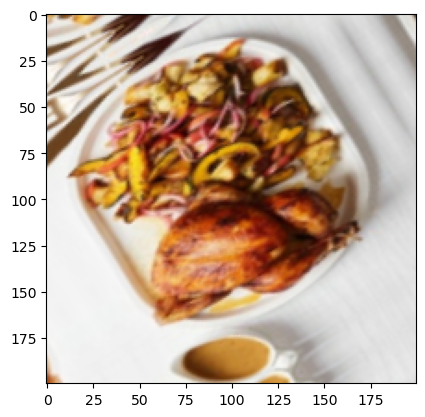

In [9]:
#apply augmentation to training input; specify training=True to ensure it is applied
train_x_augmented = train_x.map(lambda x: augment(x, training=True), num_parallel_calls=tf.data.AUTOTUNE)
train_x_resized = train_x.map(lambda x: resize_only(x, training=True), num_parallel_calls=tf.data.AUTOTUNE)
validation_x_resized = validation_x.map(lambda x: resize_only(x, training=True), num_parallel_calls=tf.data.AUTOTUNE)

#show an augmented image
for img in train_x_augmented:
    print(img.shape)
    #not sure why this is float type here, images are loaded as uint8
    #maybe keras preprocessing layers convert to float
    print(img.dtype)
    plt.figure()
    _ = plt.imshow(img / 255.) #divide by 255 here so image can be shown
    break

## Create model

In [10]:
# Load pre-trained feature extractor
if FEATURE_EXTRACTOR == "resnet":
    feature_extractor = ResNet50(include_top=False, weights='imagenet', input_shape=(CROP_SIZE, CROP_SIZE, 3))
    feature_extractor_preprocessor = resnet50_preprocess
else:
    feature_extractor = MobileNetV2(include_top=False, weights="imagenet", input_shape=(CROP_SIZE, CROP_SIZE, 3))
    feature_extractor_preprocessor = mobilenetv2_preprocess

#disable updating the feature extractor parameters
feature_extractor.trainable = False

In [11]:
#final preprocessing for pretrained feature extractor
train_x_augmented = train_x_augmented.map(feature_extractor_preprocessor, num_parallel_calls=tf.data.AUTOTUNE)
train_x_resized = train_x_resized.map(feature_extractor_preprocessor, num_parallel_calls=tf.data.AUTOTUNE)
validation_x_resized = validation_x_resized.map(feature_extractor_preprocessor, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
#create iou metric
iou = make_iou(IOU_THRESH)

#create an example model and show summary
model, ingredient_predictor = create_model_with_feature_extractor(
    num_ingredients=NUM_INGREDIENTS,
    feature_extractor=feature_extractor,
    metrics=['accuracy', iou, f1],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 ingredient_predictor (Seque  (None, 205)              420045    
 ntial)                                                          
                                                                 
Total params: 24,007,757
Trainable params: 420,045
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
#hyperparameter options to explore
hyperparameter_options = {
    "batch_size": [32, 128, 512],
    "learning_rate": [1e-3, 1e-4, 1e-5],
    "augmentation": [True, False],
    "input_dropout": [0, 0.3, 0.7]
}

choose_params(hyperparameter_options)

{'batch_size': 512,
 'learning_rate': 1e-05,
 'augmentation': True,
 'input_dropout': 0.7}

In [16]:
#define training function -- it runs with a random set of hyperparameters and
#saves the model, training history, and hyperparameter selection

def train_with_feature_extractor():
    #create iou metric
    iou = make_iou(IOU_THRESH)
    
    #create id
    uuid = str(uuid4())
    
    #choose hyperparameters randomly
    params = choose_params(hyperparameter_options)
    print("running with hyperparameters:")
    pprint.pprint(params)
    
    #create train and validation datasets by zipping/shuffling
    x = train_x_augmented if params["augmentation"] else train_x_resized
    train_ds = Dataset.zip((x, train_y))
    train_ds = train_ds.shuffle(SHUFFLE_SIZE)

    val_ds = Dataset.zip((validation_x_resized, validation_y))
    
    #create model with hyperparameters
    #also grab the ingredient predictor so we can save it separately from feature extractor
    model, ingredient_predictor = create_model_with_feature_extractor(
        num_ingredients=NUM_INGREDIENTS,
        feature_extractor=feature_extractor,
        metrics=["accuracy", iou, f1],
        learning_rate=params["learning_rate"],
#         num_hidden=params["num_hidden"],
#         hidden_size=params["hidden_size"],
        input_dropout=params["input_dropout"]
    )
    
    model.summary()
    
    #early stopping callback
    early_stopping = EarlyStopping(
        patience=EARLY_STOPPING_PATIENCE,
    )
    
    #batch datasets
    train_ds_batched = train_ds.batch(params["batch_size"])
    val_ds_batched = val_ds.batch(params["batch_size"])

    history = model.fit(
        train_ds_batched,
        validation_data=val_ds_batched,
        epochs=MAX_EPOCHS,
        callbacks=[early_stopping],
#         class_weight=class_weights
    )

    #save our ingredient predictor model (not entire resnet), training metrics (history) and hyperparams
    run_path = os.path.join(RUN_DIR, uuid)
    os.makedirs(run_path, exist_ok=True)
    
    ingredient_predictor.save(os.path.join(run_path, "ingredient_predictor.keras"))
    
    with open(os.path.join(run_path, "history.json"), "w") as f:
        f.write(json.dumps(history.history, indent=4))
    
    with open(os.path.join(run_path, "params.json"), "w") as f:
        f.write(json.dumps(params, indent=4))

while True:
    train_with_feature_extractor()

running with hyperparameters:
{'augmentation': False,
 'batch_size': 128,
 'input_dropout': 0.3,
 'learning_rate': 0.0001}
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 ingredient_predictor (Seque  (None, 208)              426192    
 ntial)                                                          
                                                                 
Total params: 24,013,904
Trainable params: 426,192
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/25
68/68 [==============================] - 51s 606ms/step - loss: 0.3416 - accuracy: 0.2810 - iou: 0.0614 - f1: 0.1152 - val_loss: 0.1553 - val_accuracy: 0.2948 - val_iou: 0.0527 - val_f1: 0.1000
Epoch 2/25
68/68 [====================

Epoch 9/25
68/68 [==============================] - 67s 927ms/step - loss: 0.1794 - accuracy: 0.5536 - iou: 0.0952 - f1: 0.1735 - val_loss: 0.1728 - val_accuracy: 0.3417 - val_iou: 0.0534 - val_f1: 0.1012
Epoch 10/25
68/68 [==============================] - 68s 920ms/step - loss: 0.1692 - accuracy: 0.5658 - iou: 0.0991 - f1: 0.1798 - val_loss: 0.1654 - val_accuracy: 0.3473 - val_iou: 0.0534 - val_f1: 0.1012
Epoch 11/25
68/68 [==============================] - 68s 932ms/step - loss: 0.1620 - accuracy: 0.5709 - iou: 0.1010 - f1: 0.1831 - val_loss: 0.1598 - val_accuracy: 0.3519 - val_iou: 0.0542 - val_f1: 0.1026
Epoch 12/25
68/68 [==============================] - 67s 916ms/step - loss: 0.1560 - accuracy: 0.5827 - iou: 0.1031 - f1: 0.1864 - val_loss: 0.1555 - val_accuracy: 0.3589 - val_iou: 0.0548 - val_f1: 0.1037
Epoch 13/25
68/68 [==============================] - 67s 915ms/step - loss: 0.1515 - accuracy: 0.5932 - iou: 0.1046 - f1: 0.1888 - val_loss: 0.1521 - val_accuracy: 0.3612 - val_

Epoch 19/25
17/17 [==============================] - 45s 3s/step - loss: 0.0998 - accuracy: 0.5979 - iou: 0.1756 - f1: 0.2985 - val_loss: 0.1232 - val_accuracy: 0.3268 - val_iou: 0.1048 - val_f1: 0.1897
Epoch 20/25
17/17 [==============================] - 46s 3s/step - loss: 0.0990 - accuracy: 0.5992 - iou: 0.1766 - f1: 0.3000 - val_loss: 0.1232 - val_accuracy: 0.3203 - val_iou: 0.1060 - val_f1: 0.1916
running with hyperparameters:
{'augmentation': True,
 'batch_size': 128,
 'input_dropout': 0.3,
 'learning_rate': 0.001}
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 ingredient_predictor (Seque  (None, 208)              426192    
 ntial)                                                          
                                                       

Epoch 19/25
68/68 [==============================] - 68s 933ms/step - loss: 0.1205 - accuracy: 0.5540 - iou: 0.1427 - f1: 0.2492 - val_loss: 0.1270 - val_accuracy: 0.3361 - val_iou: 0.0882 - val_f1: 0.1619
Epoch 20/25
68/68 [==============================] - 69s 949ms/step - loss: 0.1201 - accuracy: 0.5644 - iou: 0.1434 - f1: 0.2502 - val_loss: 0.1267 - val_accuracy: 0.3394 - val_iou: 0.0864 - val_f1: 0.1589
Epoch 21/25
68/68 [==============================] - 69s 943ms/step - loss: 0.1195 - accuracy: 0.5531 - iou: 0.1420 - f1: 0.2481 - val_loss: 0.1265 - val_accuracy: 0.3384 - val_iou: 0.0852 - val_f1: 0.1568
Epoch 22/25
68/68 [==============================] - 69s 946ms/step - loss: 0.1190 - accuracy: 0.5580 - iou: 0.1430 - f1: 0.2496 - val_loss: 0.1262 - val_accuracy: 0.3422 - val_iou: 0.0895 - val_f1: 0.1640
Epoch 23/25
68/68 [==============================] - 69s 955ms/step - loss: 0.1185 - accuracy: 0.5649 - iou: 0.1437 - f1: 0.2507 - val_loss: 0.1258 - val_accuracy: 0.3394 - val

Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/25
68/68 [==============================] - 51s 656ms/step - loss: 0.3009 - accuracy: 0.3714 - iou: 0.0718 - f1: 0.1332 - val_loss: 0.1562 - val_accuracy: 0.2549 - val_iou: 0.0516 - val_f1: 0.0980
Epoch 2/25
68/68 [==============================] - 43s 607ms/step - loss: 0.1402 - accuracy: 0.5829 - iou: 0.1119 - f1: 0.2008 - val_loss: 0.1404 - val_accuracy: 0.2776 - val_iou: 0.0582 - val_f1: 0.1099
Epoch 3/25
68/68 [==============================] - 44s 619ms/step - loss: 0.1320 - accuracy: 0.5925 - iou: 0.1193 - f1: 0.2126 - val_loss: 0.1362 - val_accuracy: 0.2818 - val_iou: 0.0638 - val_f1: 0.1198
Epoch 4/25
68/68 [==============================] - 43s 613ms/step - loss: 0.1285 - accuracy: 0.6038 - iou: 0.1263 - f1: 0.2236 - val_loss: 0.1341 - val_accuracy: 0.2837 - val_iou: 0.0697 - val_f1: 0.1302
Epoch 5/25
68/68 [==============================] - 43s 617ms/step - loss: 0.1263

Epoch 20/25
68/68 [==============================] - 44s 614ms/step - loss: 0.1170 - accuracy: 0.5516 - iou: 0.1520 - f1: 0.2634 - val_loss: 0.1243 - val_accuracy: 0.3148 - val_iou: 0.0838 - val_f1: 0.1542
Epoch 21/25
68/68 [==============================] - 43s 612ms/step - loss: 0.1165 - accuracy: 0.5531 - iou: 0.1523 - f1: 0.2638 - val_loss: 0.1240 - val_accuracy: 0.3157 - val_iou: 0.0843 - val_f1: 0.1551
Epoch 22/25
68/68 [==============================] - 43s 612ms/step - loss: 0.1156 - accuracy: 0.5661 - iou: 0.1539 - f1: 0.2662 - val_loss: 0.1238 - val_accuracy: 0.3166 - val_iou: 0.0852 - val_f1: 0.1565
Epoch 23/25
68/68 [==============================] - 44s 622ms/step - loss: 0.1150 - accuracy: 0.5705 - iou: 0.1550 - f1: 0.2679 - val_loss: 0.1235 - val_accuracy: 0.3124 - val_iou: 0.0815 - val_f1: 0.1504
Epoch 24/25
68/68 [==============================] - 43s 614ms/step - loss: 0.1146 - accuracy: 0.5495 - iou: 0.1546 - f1: 0.2674 - val_loss: 0.1233 - val_accuracy: 0.3180 - val

 ntial)                                                          
                                                                 
Total params: 24,013,904
Trainable params: 426,192
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/25
17/17 [==============================] - 86s 4s/step - loss: 0.8116 - accuracy: 0.0313 - iou: 0.0369 - f1: 0.0712 - val_loss: 0.3729 - val_accuracy: 0.1592 - val_iou: 0.0402 - val_f1: 0.0772
Epoch 2/25
17/17 [==============================] - 78s 4s/step - loss: 0.4484 - accuracy: 0.0889 - iou: 0.0425 - f1: 0.0815 - val_loss: 0.2110 - val_accuracy: 0.3171 - val_iou: 0.0487 - val_f1: 0.0929
Epoch 3/25
17/17 [==============================] - 79s 4s/step - loss: 0.2933 - accuracy: 0.1789 - iou: 0.0530 - f1: 0.1006 - val_loss: 0.1657 - val_accuracy: 0.3668 - val_iou: 0.0528 - val_f1: 0.1002
Epoch 4/25
17/17 [==============================] - 78s 4s/step - loss: 0.2307 - accuracy: 0.2530 - iou: 0.0689 

270/270 [==============================] - 76s 262ms/step - loss: 0.1286 - accuracy: 0.5392 - iou: 0.1302 - f1: 0.2295 - val_loss: 0.1325 - val_accuracy: 0.3528 - val_iou: 0.0756 - val_f1: 0.1398
Epoch 21/25
270/270 [==============================] - 75s 259ms/step - loss: 0.1284 - accuracy: 0.5305 - iou: 0.1297 - f1: 0.2287 - val_loss: 0.1322 - val_accuracy: 0.3538 - val_iou: 0.0763 - val_f1: 0.1411
Epoch 22/25
270/270 [==============================] - 78s 265ms/step - loss: 0.1277 - accuracy: 0.5376 - iou: 0.1306 - f1: 0.2301 - val_loss: 0.1319 - val_accuracy: 0.3510 - val_iou: 0.0758 - val_f1: 0.1401
Epoch 23/25
270/270 [==============================] - 76s 263ms/step - loss: 0.1273 - accuracy: 0.5393 - iou: 0.1307 - f1: 0.2301 - val_loss: 0.1316 - val_accuracy: 0.3556 - val_iou: 0.0764 - val_f1: 0.1412
Epoch 24/25
270/270 [==============================] - 76s 263ms/step - loss: 0.1269 - accuracy: 0.5379 - iou: 0.1322 - f1: 0.2326 - val_loss: 0.1313 - val_accuracy: 0.3542 - val_i

Total params: 24,013,904
Trainable params: 426,192
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/25
17/17 [==============================] - 58s 3s/step - loss: 0.5936 - accuracy: 0.0439 - iou: 0.0342 - f1: 0.0661 - val_loss: 0.3782 - val_accuracy: 0.0817 - val_iou: 0.0328 - val_f1: 0.0635
Epoch 2/25
17/17 [==============================] - 52s 3s/step - loss: 0.2806 - accuracy: 0.2670 - iou: 0.0576 - f1: 0.1088 - val_loss: 0.2219 - val_accuracy: 0.2307 - val_iou: 0.0501 - val_f1: 0.0954
Epoch 3/25
17/17 [==============================] - 50s 3s/step - loss: 0.1864 - accuracy: 0.5063 - iou: 0.0959 - f1: 0.1749 - val_loss: 0.1757 - val_accuracy: 0.3036 - val_iou: 0.0626 - val_f1: 0.1177
Epoch 4/25
17/17 [==============================] - 51s 3s/step - loss: 0.1577 - accuracy: 0.5676 - iou: 0.1086 - f1: 0.1956 - val_loss: 0.1589 - val_accuracy: 0.3171 - val_iou: 0.0640 - val_f1: 0.1202
Epoch 5/25
17/17 [========================

running with hyperparameters:
{'augmentation': False,
 'batch_size': 32,
 'input_dropout': 0.7,
 'learning_rate': 1e-05}
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 ingredient_predictor (Seque  (None, 208)              426192    
 ntial)                                                          
                                                                 
Total params: 24,013,904
Trainable params: 426,192
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/25
270/270 [==============================] - 59s 192ms/step - loss: 0.7553 - accuracy: 0.0129 - iou: 0.0360 - f1: 0.0694 - val_loss: 0.3130 - val_accuracy: 0.0515 - val_iou: 0.0416 - val_f1: 0.0796
Epoch 2/25
270/270 [=================

Total params: 24,013,904
Trainable params: 426,192
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/25
270/270 [==============================] - 96s 311ms/step - loss: 0.1327 - accuracy: 0.5666 - iou: 0.1354 - f1: 0.2373 - val_loss: 0.1261 - val_accuracy: 0.2851 - val_iou: 0.0742 - val_f1: 0.1374
Epoch 2/25
270/270 [==============================] - 85s 295ms/step - loss: 0.1155 - accuracy: 0.5857 - iou: 0.1484 - f1: 0.2573 - val_loss: 0.1256 - val_accuracy: 0.3589 - val_iou: 0.1078 - val_f1: 0.1934
Epoch 3/25
270/270 [==============================] - 86s 296ms/step - loss: 0.1114 - accuracy: 0.5865 - iou: 0.1552 - f1: 0.2676 - val_loss: 0.1266 - val_accuracy: 0.3115 - val_iou: 0.0854 - val_f1: 0.1562
Epoch 4/25
270/270 [==============================] - 92s 319ms/step - loss: 0.1086 - accuracy: 0.5889 - iou: 0.1594 - f1: 0.2736 - val_loss: 0.1278 - val_accuracy: 0.2929 - val_iou: 0.0998 - val_f1: 0.1805
Epoch 5/25
270/270 [==

                                                                 
Total params: 24,013,904
Trainable params: 426,192
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/25
68/68 [==============================] - 95s 1s/step - loss: 0.1687 - accuracy: 0.4965 - iou: 0.1207 - f1: 0.2145 - val_loss: 0.1350 - val_accuracy: 0.3333 - val_iou: 0.0757 - val_f1: 0.1404
Epoch 2/25
68/68 [==============================] - 80s 1s/step - loss: 0.1268 - accuracy: 0.5380 - iou: 0.1399 - f1: 0.2448 - val_loss: 0.1274 - val_accuracy: 0.2994 - val_iou: 0.0767 - val_f1: 0.1422
Epoch 3/25
68/68 [==============================] - 99s 1s/step - loss: 0.1216 - accuracy: 0.5548 - iou: 0.1432 - f1: 0.2498 - val_loss: 0.1252 - val_accuracy: 0.3301 - val_iou: 0.0753 - val_f1: 0.1397
Epoch 4/25
68/68 [==============================] - 83s 1s/step - loss: 0.1184 - accuracy: 0.5666 - iou: 0.1475 - f1: 0.2565 - val_loss: 0.1243 - val_accuracy: 0.3240 - val_iou: 

_________________________________________________________________
Epoch 1/25
17/17 [==============================] - 110s 6s/step - loss: 0.5883 - accuracy: 0.0751 - iou: 0.0366 - f1: 0.0707 - val_loss: 0.3723 - val_accuracy: 0.0956 - val_iou: 0.0361 - val_f1: 0.0697
Epoch 2/25
17/17 [==============================] - 91s 5s/step - loss: 0.2856 - accuracy: 0.3728 - iou: 0.0602 - f1: 0.1135 - val_loss: 0.2163 - val_accuracy: 0.2400 - val_iou: 0.0507 - val_f1: 0.0965
Epoch 3/25
17/17 [==============================] - 95s 5s/step - loss: 0.1904 - accuracy: 0.5149 - iou: 0.0892 - f1: 0.1637 - val_loss: 0.1715 - val_accuracy: 0.2962 - val_iou: 0.0572 - val_f1: 0.1081
Epoch 4/25
17/17 [==============================] - 128s 7s/step - loss: 0.1607 - accuracy: 0.5631 - iou: 0.0975 - f1: 0.1774 - val_loss: 0.1558 - val_accuracy: 0.3171 - val_iou: 0.0592 - val_f1: 0.1117
Epoch 5/25
17/17 [==============================] - 122s 7s/step - loss: 0.1482 - accuracy: 0.5778 - iou: 0.1048 - f1: 0.189

Epoch 11/25
68/68 [==============================] - 226s 3s/step - loss: 0.1027 - accuracy: 0.5894 - iou: 0.1640 - f1: 0.2810 - val_loss: 0.1245 - val_accuracy: 0.3032 - val_iou: 0.0963 - val_f1: 0.1753
running with hyperparameters:
{'augmentation': False,
 'batch_size': 32,
 'input_dropout': 0.7,
 'learning_rate': 1e-05}
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 ingredient_predictor (Seque  (None, 208)              426192    
 ntial)                                                          
                                                                 
Total params: 24,013,904
Trainable params: 426,192
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/25
270/270 [====================

KeyboardInterrupt: 

In [14]:
# curr_dir = os.path.join('best-runs', 'best-resnet-cef58318-a912-46ca-9970-4cc1da7ca1e0', 'ingredient_predictor.keras')
curr_dir = os.path.join('runs', '31e4d71b-354a-4bd7-ab6d-c4e0a6e33b7f', 'ingredient_predictor.keras')
curr_model, curr_ingredient_predictor = create_model_with_feature_extractor(
    num_ingredients=NUM_INGREDIENTS,
    feature_extractor=feature_extractor,
    metrics=['accuracy', iou, f1],
    model_file=curr_dir
)

In [15]:
curr_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 ingredient_predictor (Seque  (None, 205)              420045    
 ntial)                                                          
                                                                 
Total params: 24,007,757
Trainable params: 420,045
Non-trainable params: 23,587,712
_________________________________________________________________


In [16]:
optimizer = Adam(0.001)
curr_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', iou, f1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(200, 200, 3)
<dtype: 'float32'>


ValueError: in user code:

    File "D:\ProgramData\Anaconda3\envs\cs7643-project\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "D:\ProgramData\Anaconda3\envs\cs7643-project\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\ProgramData\Anaconda3\envs\cs7643-project\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "D:\ProgramData\Anaconda3\envs\cs7643-project\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "D:\ProgramData\Anaconda3\envs\cs7643-project\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "D:\ProgramData\Anaconda3\envs\cs7643-project\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 200, 200, 3), found shape=(None, 200, 3)


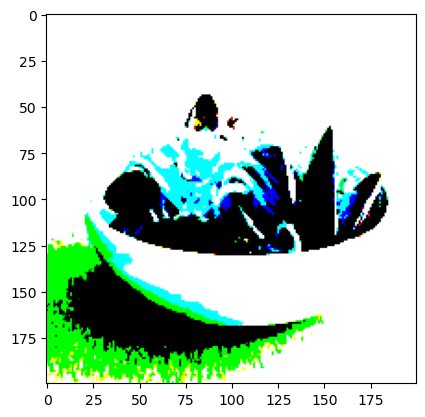

In [17]:
#show a test image
for img in validation_x_resized:
    print(img.shape)
    #not sure why this is float type here, images are loaded as uint8
    #maybe keras preprocessing layers convert to float
    print(img.dtype)
    plt.figure()
    _ = plt.imshow(img) #divide by 255 here so image can be shown
    curr_model.predict(img)
    break

In [ ]:
# fig, ax = plt.subplots()
# df_table = pd.DataFrame(np.array([predicted_sorted_ingredients, actual_sorted_ingredients]).T, columsn=['Predicted', 'Actual'])
# ax.axis('off')
# ax.axis('tight')
# ax.table(cell=df_table.values, colLabels=df_table.columns, loc='center')
# fig.tight_layout()
# plt.show()